In [1]:
import os
import random
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from src.train import train, plot_metrics
from src.models.cond_eegnet import ConditionedEEGNet
from src.dataset.MI_dataset_single_subject import MI_Dataset
from config.over60 import cfg


from utils.eval import accuracy
from utils.model import print_parameters, print_weights_statistics

%load_ext autoreload
%autoreload 2


In [2]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
train_dataset = MI_Dataset.get_concat_dataset(cfg, split='train', return_subject_id = True, device=device, verbose=False)
train_dataloader = DataLoader(train_dataset, batch_size=cfg['train']['batch_size'], shuffle=True)
print(f"Train dataset: {len(train_dataset)} samples")

test_dataset = MI_Dataset.get_concat_dataset(cfg, split='test', return_subject_id = True, device=device, verbose=False)
test_dataloader = DataLoader(test_dataset, batch_size=cfg['train']['batch_size'], shuffle=False)
print(f"Test dataset: {len(test_dataset)} samples")

Loading dataset from cache\all_subjects_with_id_1-2-3-7-8\train_dataset.pkl...
Train dataset: 1200 samples
Loading dataset from cache\all_subjects_with_id_1-2-3-7-8\test_dataset.pkl...
Test dataset: 240 samples


In [4]:
model = ConditionedEEGNet.from_config(cfg['model'], device)
print_parameters(model)

eeg_encoder.conv1.weight.... --> 1024
eeg_encoder.bn1.weight...... --> 16
eeg_encoder.bn1.bias........ --> 16
eeg_encoder.dw_conv1.weight. --> 704
eeg_encoder.bn2.weight...... --> 32
eeg_encoder.bn2.bias........ --> 32
eeg_encoder.sep_conv1.weight --> 512
eeg_encoder.conv2.weight.... --> 1024
eeg_encoder.bn3.weight...... --> 32
eeg_encoder.bn3.bias........ --> 32
subject_encoder.weight...... --> 80
subject_norm.weight......... --> 16
subject_norm.bias........... --> 16
eeg_norm.weight............. --> 384
eeg_norm.bias............... --> 384
linear.weight............... --> 4000
linear.bias................. --> 10
classifier.weight........... --> 40
classifier.bias............. --> 4

Total Parameter Count:...... --> 8358


In [5]:
# Test forward pass
#model(*next(iter(train_dataloader))[0]);

In [6]:
loss, val_loss, train_acc, val_acc = train(model, train_dataloader, test_dataloader, cfg['train'])

Epoch 10/100, Loss: 1.08425, Val Loss: 1.14640, Train accuracy: 54.50%, Test accuracy: 48.75%
Epoch 20/100, Loss: 0.92558, Val Loss: 1.17371, Train accuracy: 64.33%, Test accuracy: 51.67%
Epoch 30/100, Loss: 0.82040, Val Loss: 1.15869, Train accuracy: 67.67%, Test accuracy: 54.58%
Epoch 40/100, Loss: 0.81222, Val Loss: 1.14354, Train accuracy: 68.00%, Test accuracy: 50.83%
Epoch 50/100, Loss: 0.78396, Val Loss: 1.11822, Train accuracy: 68.42%, Test accuracy: 54.17%
Epoch 60/100, Loss: 0.75575, Val Loss: 1.14148, Train accuracy: 69.42%, Test accuracy: 51.67%
Epoch 70/100, Loss: 0.73731, Val Loss: 1.12689, Train accuracy: 71.33%, Test accuracy: 52.50%
Epoch 80/100, Loss: 0.73316, Val Loss: 1.10610, Train accuracy: 72.92%, Test accuracy: 54.17%
Epoch 90/100, Loss: 0.74940, Val Loss: 1.17314, Train accuracy: 72.33%, Test accuracy: 54.17%
Epoch 100/100, Loss: 0.72406, Val Loss: 1.13084, Train accuracy: 72.00%, Test accuracy: 52.08%
##################################################
Final tr

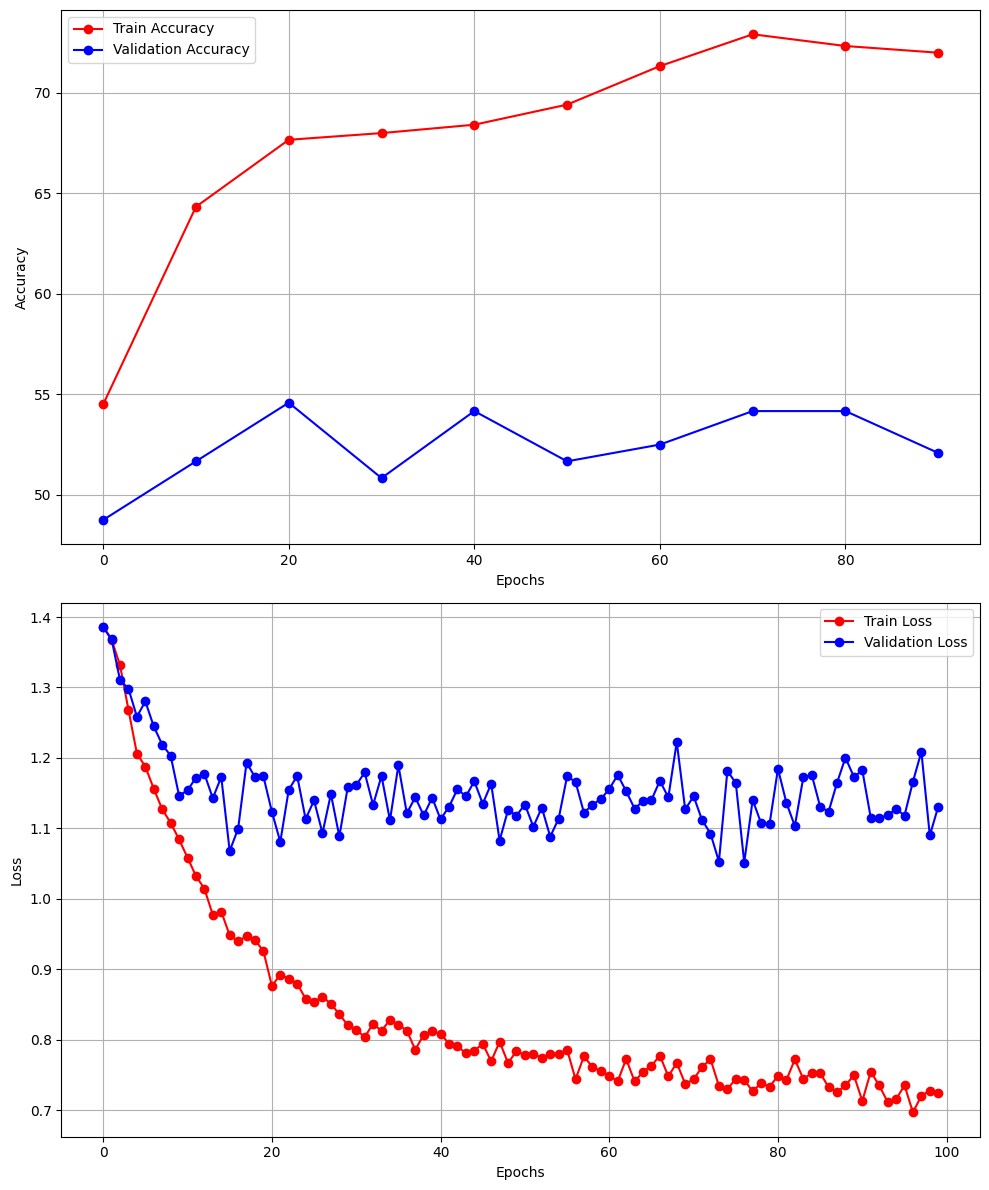

In [7]:
plot_metrics(loss, val_loss, train_acc, val_acc)

In [8]:
individual_results = [62, 60, 74, 78, 60]
average = sum(individual_results)/len(individual_results)
print(average)

66.8
